In [45]:
def limpiar_dataframe_inicial(df: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza una limpieza general inicial en el DataFrame.

    Esta función toma un DataFrame, elimina los espacios en blanco
    de las columnas de tipo 'object' (texto), convierte la columna 'date'
    a formato datetime, la ordena cronológicamente, elimina filas con
    fechas nulas y extrae la fecha y la hora en nuevas columnas.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que se va a limpiar.

    Returns:
        pd.DataFrame: El DataFrame procesado y limpio.
    """
    df_copia = df.copy()

    for col in df_copia.columns:
        if df_copia[col].dtype == 'object':
            df_copia[col] = df_copia[col].str.strip()

    df_copia['date'] = pd.to_datetime(df_copia['date'], dayfirst=True)
    df_copia = df_copia.sort_values(by='date', ascending=True)
    df_copia = df_copia.dropna(subset=['date'])

    #df_copia['fecha'] = df_copia['date'].dt.date
    #df_copia['hora'] = df_copia['date'].dt.time
    #df_copia = df_copia.replace(['nan', 'NaN', 'None', 'NULL', 'null'], np.nan)


    return df_copia

def limpiar_columnas_categoricas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia y estandariza las columnas categóricas del DataFrame.

    Esta función corrige valores mal escritos y maneja los datos nulos
    en las columnas 'WeekStatus', 'Day_of_week' y 'Load_Type'.
    Los valores incorrectos se reemplazan por su versión correcta y los
    nulos se rellenan utilizando el método 'forward fill'.

    Args:
        df (pd.DataFrame): DataFrame con las columnas categóricas a limpiar.

    Returns:
        pd.DataFrame: DataFrame con las columnas categóricas estandarizadas.
    """
    df_copia = df.copy()

    # Mapeo de correcciones para cada columna
    mapa_correcciones = {
        'WeekStatus': {
            'wEEKDAY': 'Weekday', 'wEEKEND': 'Weekend', 'NAN': np.nan
        },
        'Day_of_week': {
            'mONDAY': 'Monday', 'tUESDAY': 'Tuesday', 'wEDNESDAY': 'Wednesday',
            'tHURSDAY': 'Thursday', 'fRIDAY': 'Friday', 'sATURDAY': 'Saturday',
            'sUNDAY': 'Sunday', 'NAN': np.nan
        },
        'Load_Type': {
            'lIGHT_lOAD': 'Light_Load', 'mEDIUM_lOAD': 'Medium_Load',
            'mAXIMUM_lOAD': 'Maximum_Load', 'NAN': np.nan
        }
    }

    columnas_categoricas = ['WeekStatus', 'Day_of_week', 'Load_Type']

    for col in columnas_categoricas:
        df_copia[col] = df_copia[col].replace(mapa_correcciones[col])
        df_copia[col] = df_copia[col].astype(str)

    return df_copia


def limpiar_columnas_numericas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia y estandariza un conjunto predefinido de columnas numéricas.

    La función identifica valores no numéricos en columnas que deberían serlo,
    los convierte a NaN (Not a Number) y luego utiliza el método 'forward fill'
    para imputar los valores faltantes. Finalmente, asegura que todas las
    columnas procesadas tengan el tipo de dato 'float'.

    Args:
        df (pd.DataFrame): DataFrame con columnas numéricas a procesar.

    Returns:
        pd.DataFrame: DataFrame con las columnas numéricas limpias y
                      en formato float.
    """
    df_copia = df.copy()

    columnas_numericas = [
        'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
        'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
        'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
        'NSM', 'mixed_type_col'
    ]

    for col in columnas_numericas:
        # Forzar valores no numéricos a NaN
        df_copia[col] = pd.to_numeric(df_copia[col], errors='coerce')

        # Asegurar el tipo float
        df_copia[col] = df_copia[col].astype(float)

    return df_copia


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.decomposition import PCA

class SteelEnergyEDA:
    """
    Clase para realizar análisis exploratorio de datos (EDA), limpieza, visualización y preprocesamiento
    de un dataset de energía y acero.

    Esta clase carga datos desde un archivo CSV, realiza limpieza inicial, genera visualizaciones,
    aplica transformaciones y guarda los datos procesados.

    Attributes:
        file_path (str): Ruta del archivo CSV que contiene el dataset.
        df (pd.DataFrame): DataFrame cargado desde el archivo.
        num_cols (list): Lista de nombres de columnas numéricas.
        cat_cols (list): Lista de nombres de columnas categóricas.
        scaler (StandardScaler): Objeto de escalado para normalizar datos numéricos.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.num_cols = []
        self.cat_cols = []
        self.scaler = None

    # Cargar Datos
    def load_data(self):
        """
        Carga el dataset desde un archivo CSV en el atributo `df`.

        Returns:
            pd.DataFrame: Primeras filas del dataset cargado.
        """
        self.df = pd.read_csv(self.file_path)
        print(f"Se cargo el dataset correctamente: {self.df.shape}")
        
        return self.df.head()

    # Resumen Básico
    def basic_summary(self):
        print("\n--- INFO ---")
        self.df.info()
        print("\n--- STATS ---")
        display(self.df.describe())


    def visualize(self):
        """
        Genera visualizaciones para el dataset.

        Incluye:
            - Heatmap de correlación para variables numéricas.
            - Histogramas para cada variable numérica.
            - Pairplot para correlaciones.
            - Gráficos de barras para variables categóricas.
        """
        sns.set(style="whitegrid", palette="muted", font_scale=1.1)

        # 1. HeatMap Correlación
        if len(self.num_cols) > 1:
            plt.figure(figsize=(10, 8))
            corr = self.df[self.num_cols].corr()
            sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
            plt.title("Correlation Heatmap", fontsize=16)
            plt.show()

        # 2. Histogramas Variables Numéricas
        for col in self.num_cols:
            plt.figure(figsize=(6, 4))
            sns.histplot(self.df[col], kde=True, color="skyblue", edgecolor="black")
            plt.title(f"Distribution of {col}", fontsize=14)
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()

        # 3. Pairplot para correlaciones de variables numéricas
        if len(self.num_cols) > 1:
            sns.pairplot(self.df[self.num_cols], corner=True, diag_kind="kde")
            plt.suptitle("Pairplot of Numeric Variables", y=1.02, fontsize=16)
            plt.show()

        # 4. Bar charts para variables categóricas
        for col in self.cat_cols:
            plt.figure(figsize=(8, 5))
            sns.countplot(x=col, data=self.df, order=self.df[col].value_counts().index, palette="pastel")
            plt.title(f"Count of {col}", fontsize=14)
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()


    def clean_data(self):
        """
        Realiza limpieza del dataset.

        Pasos:
            - Limpieza general usando funciones externas.
            - Reemplazo de valores nulos estándar.
            - Identificación de columnas numéricas y categóricas.
            - Eliminación de duplicados.
            - Imputación de valores faltantes.
            - Eliminación de outliers usando método IQR.

        Returns:
            pd.DataFrame: Primeras filas del dataset limpio.
        """
        print("\n--- LIMPIEZA ---")

        initial_shape = self.df.shape

        ## Limpieza General
        self.df = limpiar_dataframe_inicial(self.df)
        self.df = limpiar_columnas_categoricas(self.df)
        self.df = limpiar_columnas_numericas(self.df)
        self.df = self.df.replace(['nan', 'NaN', 'None', 'NULL', 'null'], np.nan)


        self.num_cols = self.df.select_dtypes(include=np.number).columns
        self.cat_cols = self.df.select_dtypes(include=['object', 'category']).columns

        # Eliminar duplicados
        self.df = self.df.drop_duplicates()

        # Valores Faltantes
        self.df[self.num_cols] = self.df[self.num_cols].fillna(self.df[self.num_cols].median())
        for col in self.cat_cols:
            self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

        # Quitar outliers (IQR)
        for col in self.num_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower) & (self.df[col] <= upper)]

        print(f"Resultados de Limpieza de datos: {initial_shape[0]} → {self.df.shape[0]} rows")
        return self.df.head()

    def preprocess_data(self):
        """
        Realiza preprocesamiento del dataset.

        Incluye:
            - Extracción de características temporales.
            - Encoding cíclico para variables de fecha.
            - Normalización de características numéricas.
            - Encoding de variables categóricas ordinales.
            - Creación de un DataFrame procesado listo para análisis o modelos.

        Returns:
            pd.DataFrame: Dataset procesado.
        """
        print("\n--- PREPROCESAMIENTO ---")

        print(self.cat_cols)
        print(self.num_cols)

        # Extraer features de tiempo
        self.df[f'date_hour'] = self.df["date"].dt.hour
        self.df[f'date_day'] = self.df["date"].dt.day
        self.df[f'date_month'] = self.df["date"].dt.month
        self.df[f'date_year'] = self.df["date"].dt.year

        # Encoding ciclico
        for col, max_val in [('date_hour', 24), ('date_month', 12), ('date_day', 31)]:
            self.df[f'{col}_sin'] = np.sin(2 * np.pi * self.df[col] / max_val)
            self.df[f'{col}_cos'] = np.cos(2 * np.pi * self.df[col] / max_val)

        

        # Dividir Features
        numeric_features = [
            'CO2(tCO2)', 'NSM',
            'Leading_Current_Reactive_Power_kVarh',
            'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',                        
            'date_hour_sin', 'date_hour_cos',
            'date_day_sin', 'date_day_cos',
            'date_month_sin', 'date_month_cos',
            'date_year'
        ]
        numeric_features = [col for col in numeric_features if col in self.df.columns]

        weekstatus_feature = ['WeekStatus'] if 'WeekStatus' in self.df.columns else []
        ordinal_features = ['Load_Type'] if 'Load_Type' in self.df.columns else []

        # Pipelines
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        weekstatus_transformer = Pipeline(steps=[
            ('label', OrdinalEncoder())
        ])

        ordinal_transformer = Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[["Light_Load", "Medium_Load", "Maximum_Load"]]))
        ])

        # Transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('week', weekstatus_transformer, weekstatus_feature),
                ('ord', ordinal_transformer, ordinal_features)
            ],
            sparse_threshold=0

        )

        self.df_processed = preprocessor.fit_transform(self.df)

        processed_cols = numeric_features


        if weekstatus_feature:
            processed_cols += weekstatus_feature

        if ordinal_features:
            processed_cols += ordinal_features

        print("Shape of processed data:", self.df_processed.shape)
        print("Number of processed columns:", len(processed_cols))

        self.df_processed = pd.DataFrame(self.df_processed, columns=processed_cols)
        self.save_data(self.df_processed)

        return self.df_processed


    def save_data(self, df, output_path="cleaned_steel_energy_v2.csv"):
        """
        Guarda el DataFrame procesado en un archivo CSV.

        Args:
            df (pd.DataFrame): Dataset a guardar.
            output_path (str): Ruta del archivo de salida (default: "cleaned_steel_energy_v2.csv").
        """
        df.to_csv(output_path, index=False)
        print(f"Saved cleaned dataset to '{output_path}'")




Se cargo el dataset correctamente: (35740, 12)

--- LIMPIEZA ---
Resultados de Limpieza de datos: 35740 → 22030 rows

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
Index: 22030 entries, 95 to 35036
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  22030 non-null  datetime64[ns]
 1   Usage_kWh                             22030 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  22030 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  22030 non-null  float64       
 4   CO2(tCO2)                             22030 non-null  float64       
 5   Lagging_Current_Power_Factor          22030 non-null  float64       
 6   Leading_Current_Power_Factor          22030 non-null  float64       
 7   NSM                                   22030 non-null  float64       
 8   WeekStatus         

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,mixed_type_col
count,22030,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.0,22030.000000,22030.000000
mean,2018-06-28 19:00:43.508851456,29.844931,15.405889,0.013454,0.012778,72.784369,100.0,36210.666273,496.524194
min,2018-01-01 00:00:00,2.450000,0.000000,0.000000,0.000000,37.870000,100.0,0.000000,0.000000
25%,2018-04-02 06:48:45,3.130000,4.610000,0.000000,0.000000,55.560000,100.0,15300.000000,349.000000
50%,2018-06-28 20:07:30,4.610000,5.940000,0.000000,0.000000,73.740000,100.0,30600.000000,495.000000
75%,2018-09-26 06:11:15,56.340000,27.000000,0.000000,0.030000,90.060000,100.0,55800.000000,638.000000
max,2018-12-31 23:15:00,123.740000,51.480000,7.700000,0.050000,100.000000,100.0,118800.000000,999.000000
std,NaN,32.825498,14.150882,0.186941,0.015882,17.900911,0.0,24918.212413,242.378032


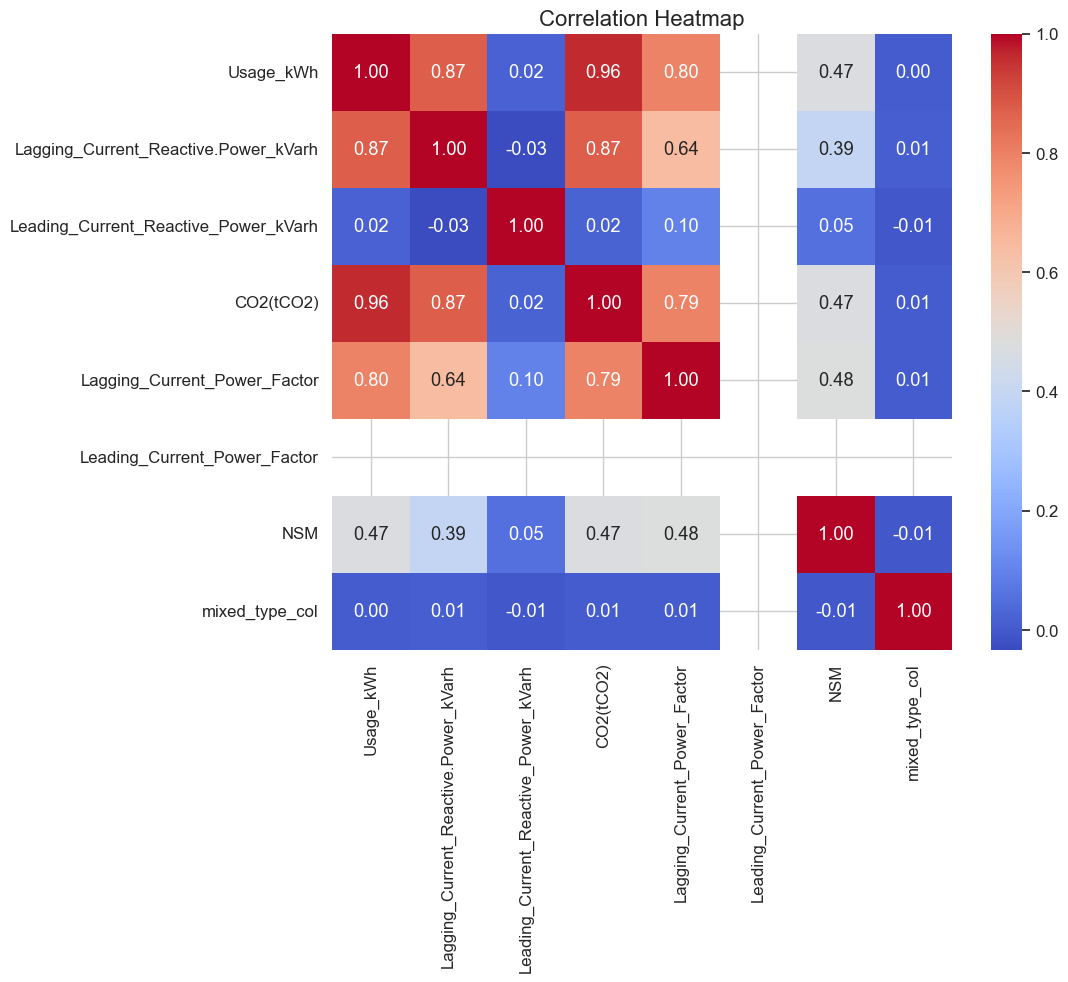

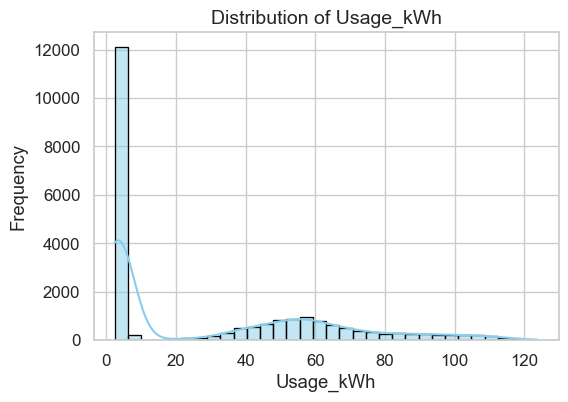

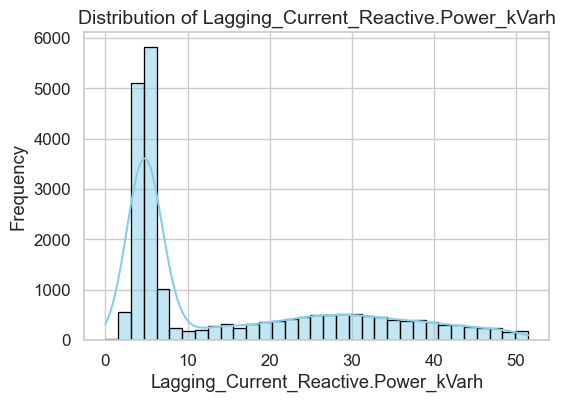

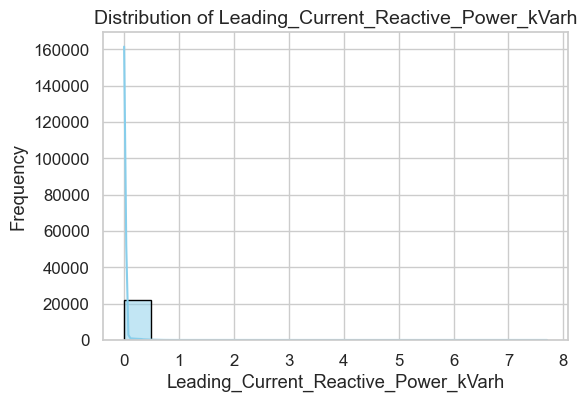

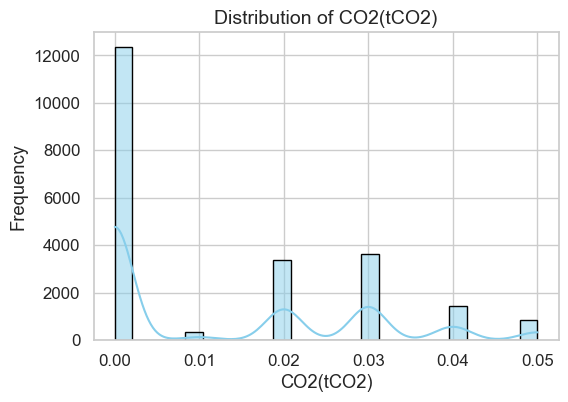

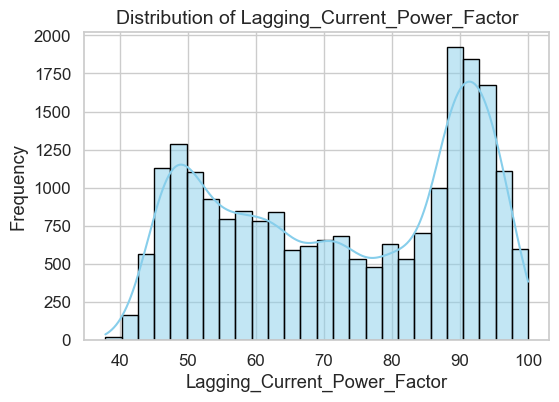

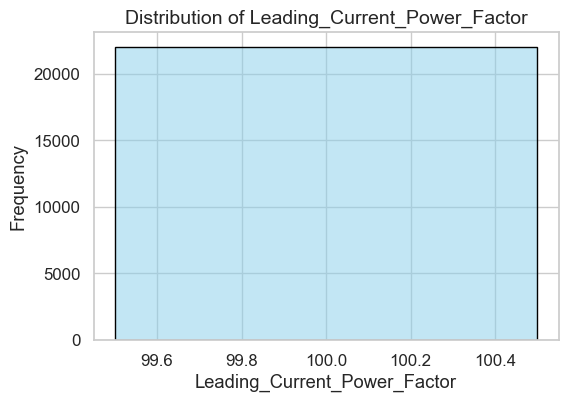

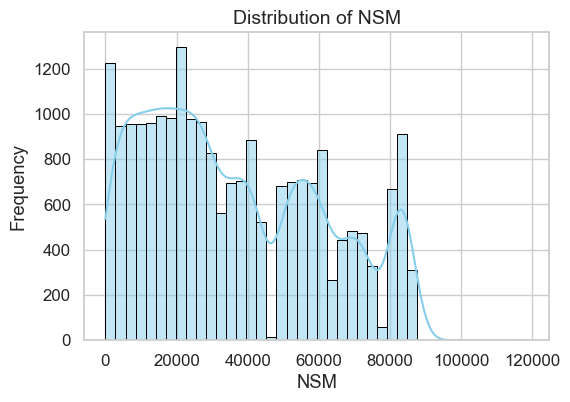

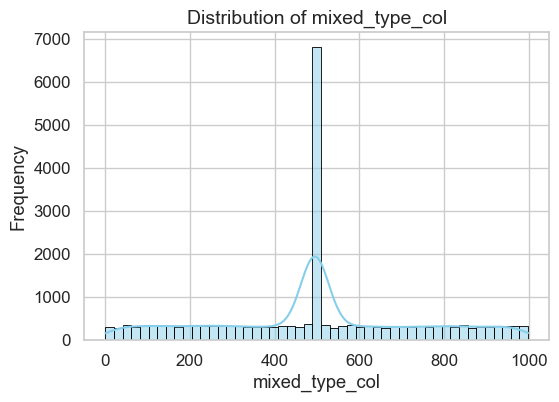

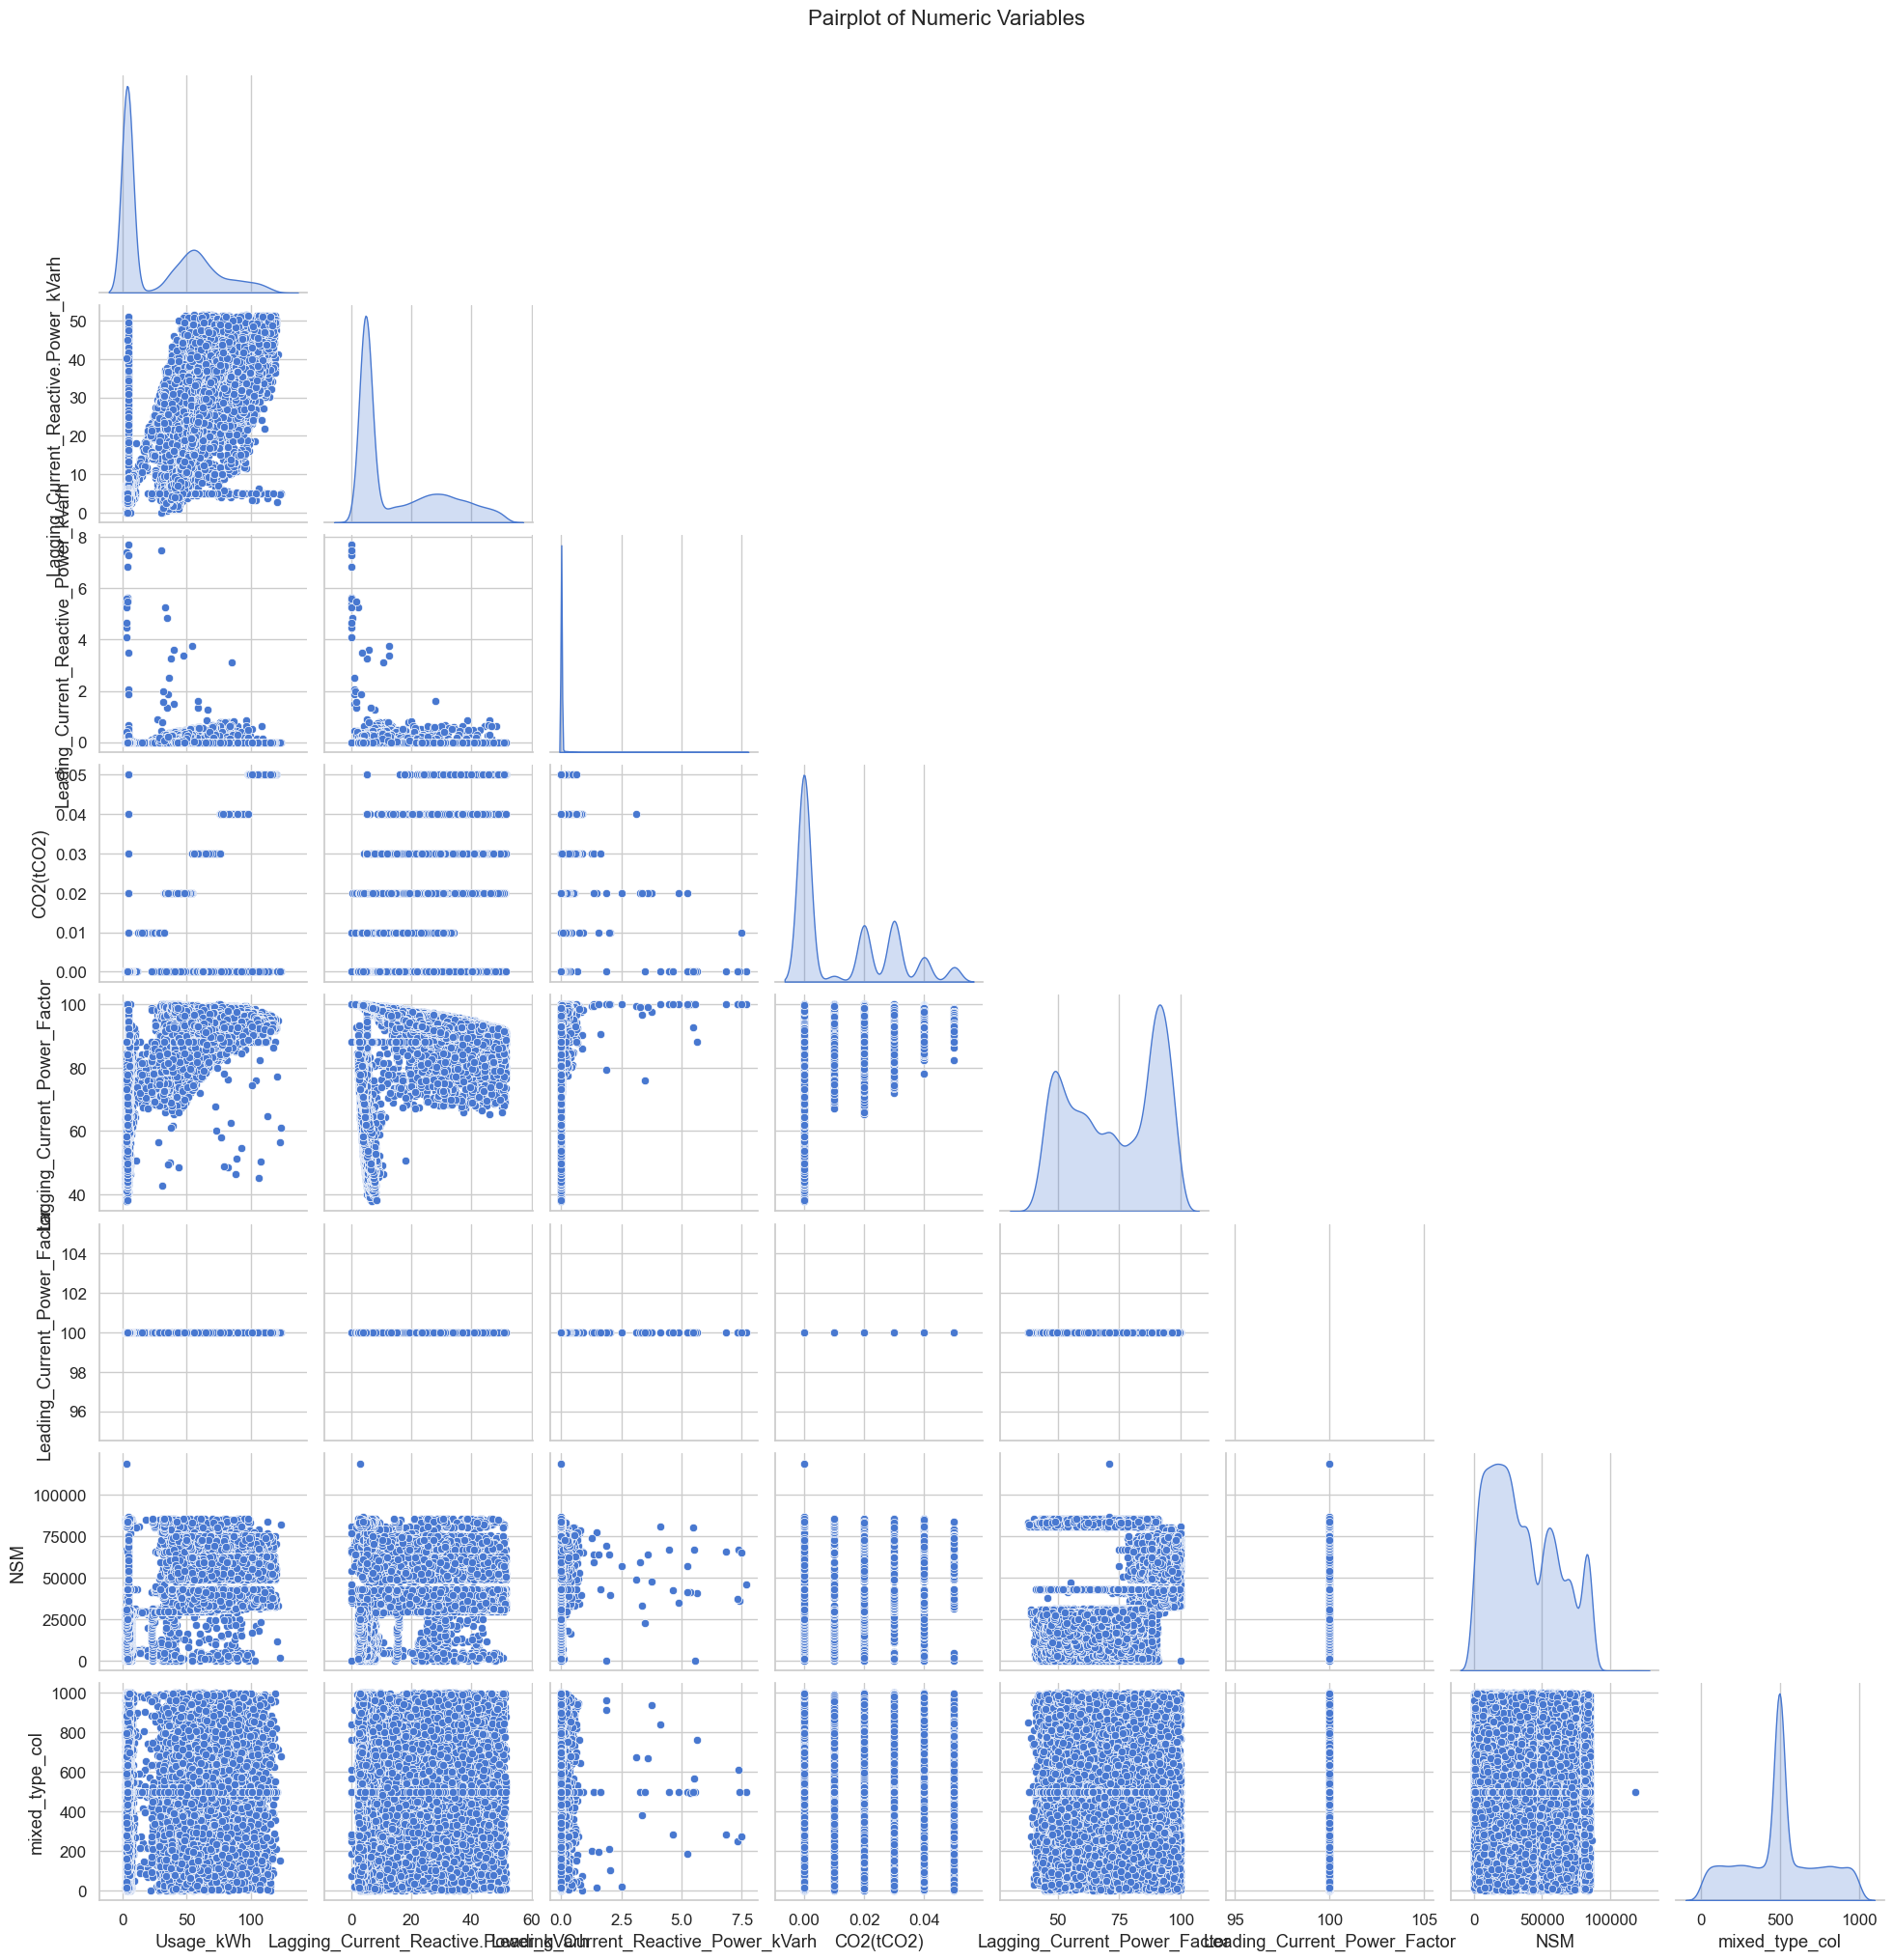

/var/folders/rn/40hby7s12mgdp8v8rm19nvn00000gr/T/ipykernel_88058/1325500789.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=self.df, order=self.df[col].value_counts().index, palette="pastel")


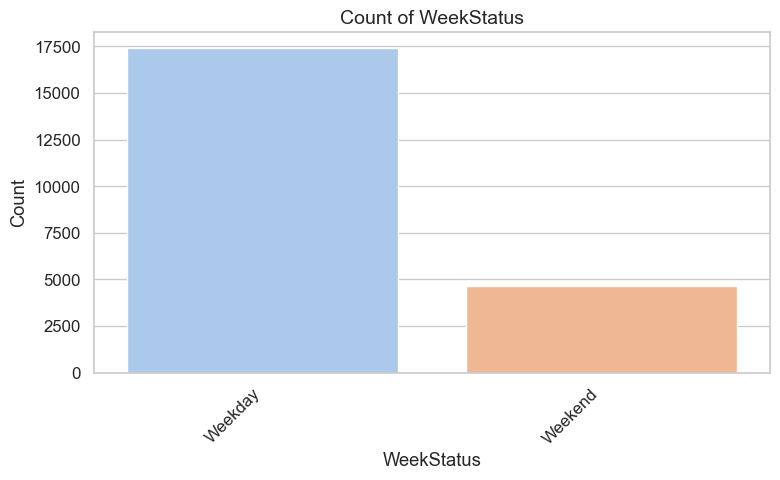

/var/folders/rn/40hby7s12mgdp8v8rm19nvn00000gr/T/ipykernel_88058/1325500789.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=self.df, order=self.df[col].value_counts().index, palette="pastel")


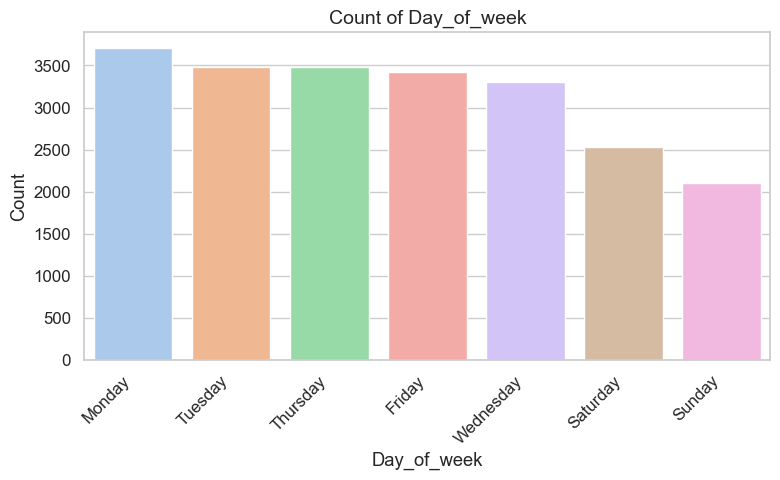

/var/folders/rn/40hby7s12mgdp8v8rm19nvn00000gr/T/ipykernel_88058/1325500789.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=self.df, order=self.df[col].value_counts().index, palette="pastel")


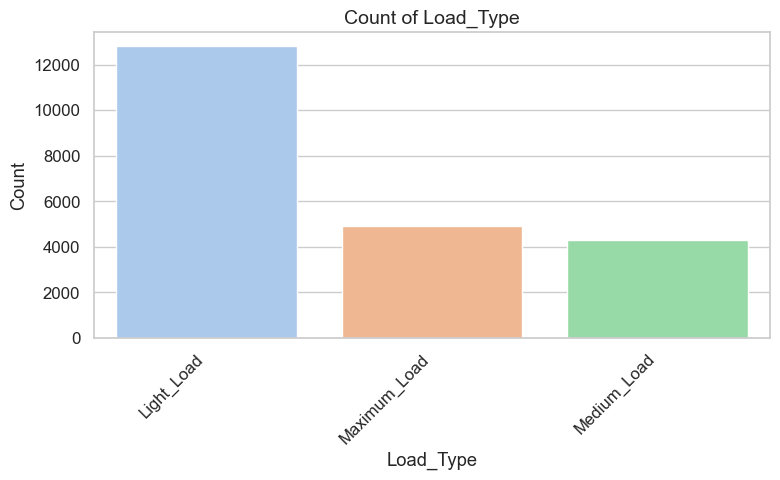


--- PREPROCESAMIENTO ---
Index(['WeekStatus', 'Day_of_week', 'Load_Type'], dtype='object')
Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'mixed_type_col'],
      dtype='object')
💾 Saved cleaned dataset to 'cleaned_steel_energy2.csv'
Shape of processed data: (22030, 14)
Number of processed columns: 14


,CO2(tCO2),NSM,Leading_Current_Reactive_Power_kVarh,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,date_hour_sin,date_hour_cos,date_day_sin,date_day_cos,date_month_sin,date_month_cos,date_year,WeekStatus,Load_Type
count,2.203000e+04,2.203000e+04,2.203000e+04,2.203000e+04,22030.0,2.203000e+04,2.203000e+04,2.203000e+04,22030.000000,22030.000000,22030.000000,22030.0,22030.000000,22030.000000
mean,-2.064219e-17,-1.277235e-16,2.580273e-17,1.032109e-17,0.0,4.644492e-17,4.644492e-17,-3.870410e-17,0.000000,0.000000,0.000000,0.0,0.210123,0.642805
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,0.0,1.000023e+00,1.000023e+00,1.000023e+00,1.000023,1.000023,1.000023,0.0,0.407405,0.822486
min,-8.046305e-01,-1.453214e+00,-7.197292e-02,-1.950468e+00,0.0,-1.717906e+00,-1.568399e+00,-1.424670e+00,-1.397917,-1.378168,-1.389335,0.0,0.000000,0.000000
25%,-8.046305e-01,-8.391911e-01,-7.197292e-02,-9.622281e-01,0.0,-9.927529e-01,-8.486026e-01,-1.041100e+00,-1.060395,-1.191047,-1.197201,0.0,0.000000,0.000000
50%,-8.046305e-01,-2.251684e-01,-7.197292e-02,5.338570e-02,0.0,1.077674e-01,2.437873e-01,-2.618877e-02,-0.048151,0.018523,0.044772,0.0,0.000000,0.000000
75%,1.084398e+00,7.861631e-01,-7.197292e-02,9.650918e-01,0.0,9.884029e-01,1.117917e+00,9.887228e-01,1.009133,0.716868,0.761826,0.0,0.000000,1.000000
max,2.343750e+00,3.314492e+00,4.111844e+01,1.520383e+00,0.0,1.182707e+00,1.310786e+00,1.372292e+00,1.453756,1.415213,1.478879,0.0,1.000000,2.000000


In [58]:
# Pipeline
eda = SteelEnergyEDA("steel_energy_modified.csv")

# 1. Cargar Datos
eda.load_data()

# 2. Limpiar Datos
eda.clean_data()

# 3. Resumen 
eda.basic_summary()

# 4. Visualizaciones
eda.visualize()

# 5. Preprocessamiento
output = eda.preprocess_data()

output.head()
output.describe()



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

class SteelEnergyModeling:
    """
    Clase para entrenar modelos de machine learning sobre datos procesados.
    
    Attributes:
        df_processed (pd.DataFrame): DataFrame con los datos ya procesados por SteelEnergyEDA.
        target_col (str): Nombre de la columna objetivo a predecir.
        X_train (pd.DataFrame): Features de entrenamiento.
        X_test (pd.DataFrame): Features de prueba.
        y_train (pd.Series): Target de entrenamiento.
        y_test (pd.Series): Target de prueba.
        models (dict): Diccionario con los modelos entrenados {'nombre_modelo': modelo}.
    """
    
    def __init__(self, df_processed, target_col='Usage_kWh'):
        """
        Inicializa el objeto SteelEnergyModeling.
        
        Args:
            df_processed (pd.DataFrame): DataFrame procesado que contiene features y target.
            target_col (str): Nombre de la columna objetivo. Default: 'Usage_kWh'.
        """
        self.df_processed = df_processed
        self.target_col = target_col
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        
    def prepare_data(self, test_size=0.2, random_state=42):
        """
        Divide los datos en conjuntos de entrenamiento y prueba.
        
        Args:
            test_size (float): Proporción del conjunto de prueba (0-1). Default: 0.2.
            random_state (int): Semilla para reproducibilidad. Default: 42.
            
        Returns:
            None. Actualiza los atributos X_train, X_test, y_train, y_test del objeto.
        """
        X = self.df_processed.drop(columns=[self.target_col])
        y = self.df_processed[self.target_col]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        print(f"Train: {self.X_train.shape}, Test: {self.X_test.shape}")
        
    def train_linear_regression(self):
        """
        Entrena un modelo de regresión lineal.
        
        Args:
            None.
            
        Returns:
            None. Guarda el modelo entrenado en self.models['linear_regression'] 
            e imprime el R² en el conjunto de prueba.
        """
        lr = LinearRegression()
        lr.fit(self.X_train, self.y_train)
        self.models['linear_regression'] = lr
        
        y_pred = lr.predict(self.X_test)
        print(f"Linear Regression - R²: {r2_score(self.y_test, y_pred):.4f}")
        
    def train_xgboost(self, **params):
        """
        Entrena un modelo XGBoost.
        
        Args:
            **params: Parámetros opcionales para XGBRegressor (ej: n_estimators=100, 
                     max_depth=6, learning_rate=0.1, random_state=42).
            
        Returns:
            None. Guarda el modelo entrenado en self.models['xgboost'] 
            e imprime el R² en el conjunto de prueba.
        """
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(self.X_train, self.y_train)
        self.models['xgboost'] = xgb_model
        
        y_pred = xgb_model.predict(self.X_test)
        print(f"XGBoost - R²: {r2_score(self.y_test, y_pred):.4f}")